# Connection


In [7]:
# libraries
import pandas as pd
import sqlite3
import sqlalchemy as sa
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns
import datetime

In [5]:
#connection
csv_file_path = 'https://drive.google.com/uc?id=1_28-2YBp9o1jH2Xf4dEt9mX6WCVzAAmb'
data = pd.read_csv(csv_file_path)

# Data Validation and Cleaning

In [9]:
#dataset info
print(data.info())
print( )
#check for missing values
print(data.isnull().sum())
print( )
#persentage of missing data
print('Missing data percentage: ',1074/15000*100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   week               15000 non-null  int64  
 1   sales_method       15000 non-null  object 
 2   customer_id        15000 non-null  object 
 3   nb_sold            15000 non-null  int64  
 4   revenue            15000 non-null  float64
 5   years_as_customer  15000 non-null  int64  
 6   nb_site_visits     15000 non-null  int64  
 7   state              15000 non-null  object 
dtypes: float64(1), int64(4), object(3)
memory usage: 937.6+ KB
None

week                 0
sales_method         0
customer_id          0
nb_sold              0
revenue              0
years_as_customer    0
nb_site_visits       0
state                0
dtype: int64

Missing data percentage:  7.16


In [10]:
#7.16% data in revenue column is missing.
#I use mean imputation to fill these gaps.
data['revenue'] = data['revenue'].fillna(data['revenue'].mean())

In [11]:
#duplicates
data.duplicated().sum()

0

In [12]:
#checking existing sales methods
data['sales_method'].unique()

array(['Email', 'Email + Call', 'Call'], dtype=object)

In [13]:
#unifiying sales methods
data['sales_method'] = data['sales_method'].replace({
    'em + call': 'Email + Call',
    'email': 'Email',
    'Email + Call': 'Email + Call'
})

In [14]:
#cheking that changes are in place
print('Sale methods:', data['sales_method'].unique())
print('NaNs in revenue:', data['revenue'].isnull().sum())

Sale methods: ['Email' 'Email + Call' 'Call']
NaNs in revenue: 0


In [15]:
#checking for anomalies
#values can't be negative
#company was established in 1984

invalid_weeks = data[data['week'] < 0]
print(invalid_weeks)

invalid_nb_sold = data[data['nb_sold'] < 0]
print(invalid_nb_sold)

invalid_revenue = data[data['revenue'] < 0]
print(invalid_revenue)

current_year = datetime.datetime.now().year
invalid_years_as_customer = data[(data['years_as_customer'] < 0) | (data['years_as_customer'] > current_year-1984)]
print(invalid_years_as_customer)

invalid_nb_site_visits = data[data['nb_site_visits'] < 0]
print(invalid_nb_site_visits)
#there is no negative values in corresponding columns
#two rows contain invalid values in the years_as_customer column.

Empty DataFrame
Columns: [week, sales_method, customer_id, nb_sold, revenue, years_as_customer, nb_site_visits, state]
Index: []
Empty DataFrame
Columns: [week, sales_method, customer_id, nb_sold, revenue, years_as_customer, nb_site_visits, state]
Index: []
Empty DataFrame
Columns: [week, sales_method, customer_id, nb_sold, revenue, years_as_customer, nb_site_visits, state]
Index: []
       week sales_method                           customer_id  nb_sold  \
13741     2        Email  18919515-a618-430c-9a05-2c7d8fea96af       10   
13800     4         Call  2ea97d34-571d-4e1b-95be-fea1c404649f       10   

       revenue  years_as_customer  nb_site_visits       state  
13741    97.22                 63              24  California  
13800    50.47                 47              27  California  
Empty DataFrame
Columns: [week, sales_method, customer_id, nb_sold, revenue, years_as_customer, nb_site_visits, state]
Index: []


In [16]:
#dropping these two rows

invalid_years_mask = (data['years_as_customer'] < 0) | (data['years_as_customer'] > (current_year - 1984))
data_cleaned = data[~invalid_years_mask]
data_cleaned.reset_index(drop=True, inplace=True)
data_cleaned.shape[0]


14998

# EDA

## Customer Count per Sales Method

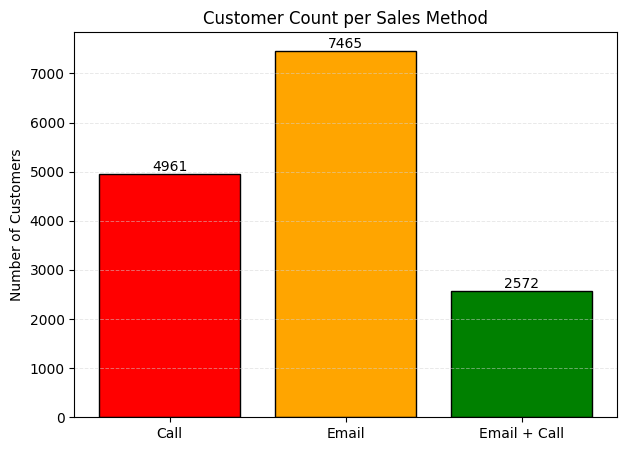

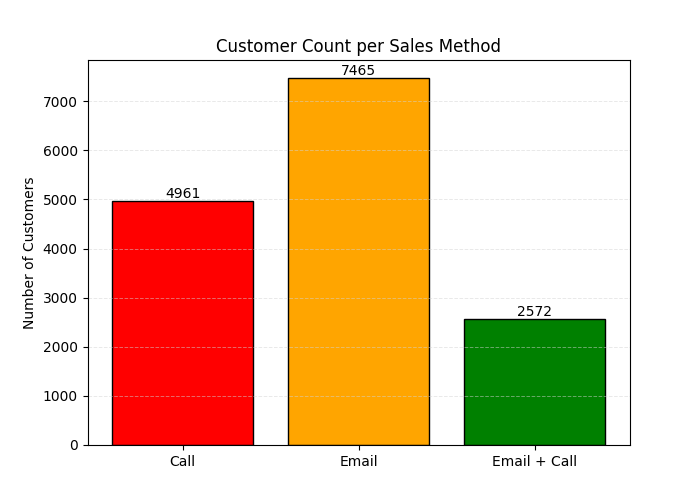

In [26]:
#customer count per sales method
customer_count_per_method = data_cleaned.groupby('sales_method')['customer_id'].nunique()
colors = ['red', 'orange', 'green']

#bar chart
plt.figure(figsize=(7, 5))

bars = plt.bar(customer_count_per_method.index,
               customer_count_per_method.values,
               color=colors,
               edgecolor='black')


plt.ylabel('Number of Customers')
plt.title('Customer Count per Sales Method')
plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.5)


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval,
             int(yval), ha='center', va='bottom')

plt.savefig('customer_count_per_sales_method.png')
plt.show()

Image(filename="customer_count_per_sales_method.png")

The analysis of customer engagement through different sales methods reveals the following results:

* **Email**: 7,465 customers engaged, making it the most widely used approach, likely due to its low effort and broad reach.
* **Call**: 4,961 customers engaged, showing a substantial level of personal interaction that can strengthen customer relationships, though it demands more resources.
* **Email + Call**: 2,572 customers engaged, indicating that this combined strategy is notably less utilized compared to the other methods.

The stark contrast between the Email + Call approach and the other methods highlights a significant gap, with 4,893 fewer customers compared to Email and 2,398 fewer than the Call method. This suggests that while personal engagement is valuable, the combined strategy may not be as effective in maximizing customer reach. Further analysis is needed to evaluate its impact on sales performance and customer satisfaction.

## General Revenue Distribution

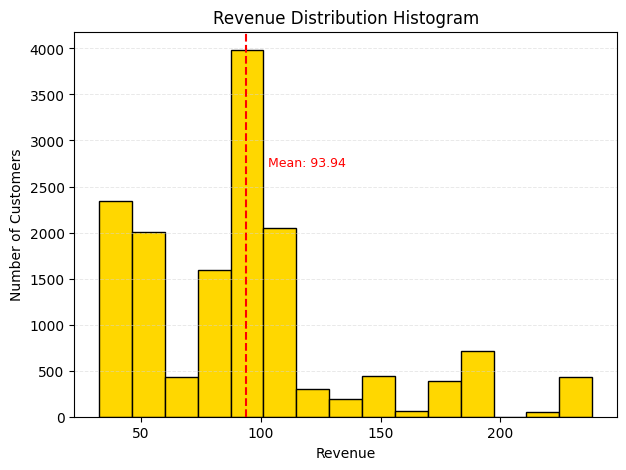

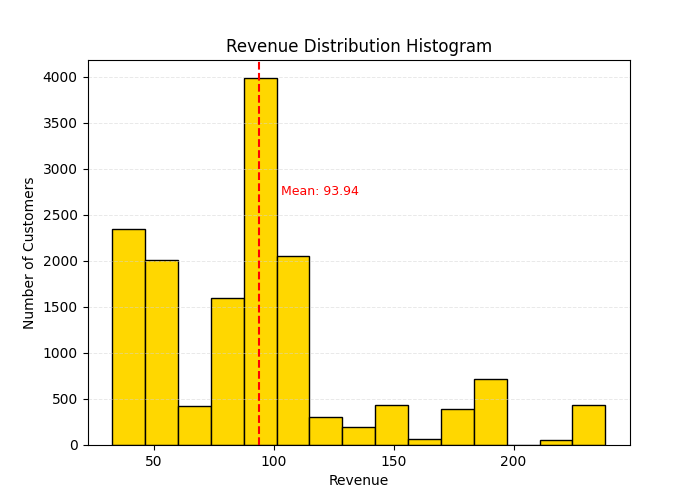

In [25]:
#revenue distribution
revenue_data = data_cleaned['revenue']

# bins number according to the Sturges' rule
n = len(revenue_data)
num_bins = int(np.ceil(np.log2(n) + 1))

# histogram
plt.figure(figsize=(7, 5))

plt.hist(revenue_data,
         bins=num_bins,
         color='gold',
         edgecolor='black')

plt.title('Revenue Distribution Histogram')
plt.xlabel('Revenue')
plt.ylabel('Number of Customers')
plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.5)

mean_revenue = revenue_data.mean()
plt.axvline(mean_revenue, color='red', linestyle='--')
plt.text(mean_revenue + 9, 0.65 * plt.ylim()[1], f'Mean: {mean_revenue:.2f}',
         color='red', fontsize=9)

plt.savefig('revenue_distribution.png')
plt.show()

Image(filename="revenue_distribution.png")

* The most common **revenue range** is around **100**, with nearly 4,000 customers falling into this category.
* There are **significant numbers of customers with lower revenues**, particularly between 50 and 75, as well as a smaller peak around 30-40.
* **Higher revenue values**, above 150, are **much less frequent**, with only a few customers generating revenue in the 200+ range.
* The **revenue distribution is right-skewed**, with the majority of customers concentrated around 100, and a long tail representing fewer customers generating higher revenue.

Most customers contribute around 100 in revenue, with fewer generating significantly higher amounts. This aligns with earlier findings where methods like Email + Call show higher variability and potential for larger revenues, though these high-revenue cases are rare.








## Revenue Distribution by Sales Method

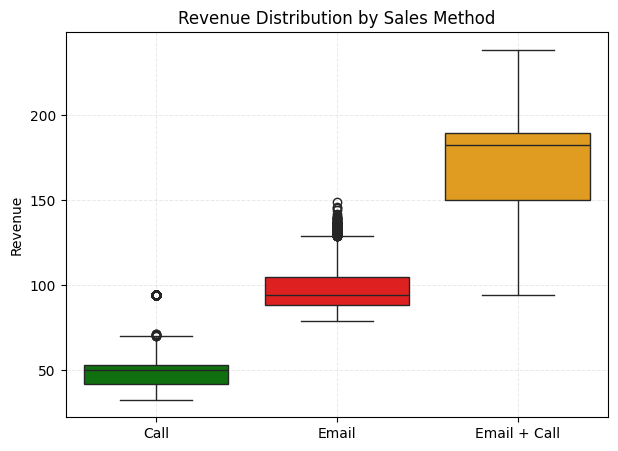

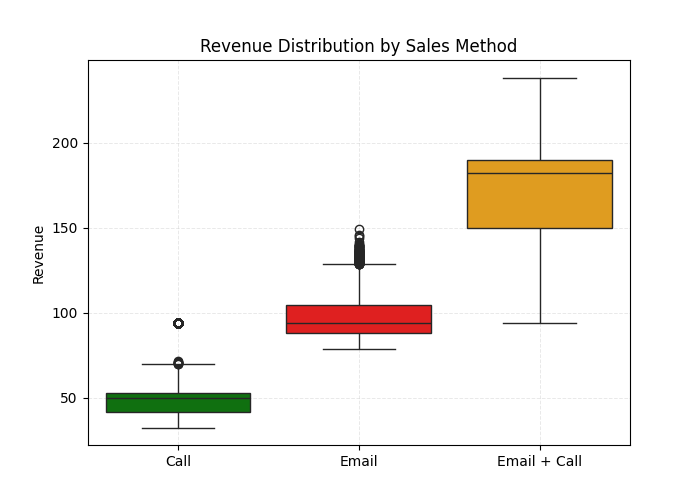

In [24]:
# revenue distribution by sales method
revenue_distribution = data_cleaned[['sales_method', 'revenue']]

# box plot
plt.figure(figsize=(7, 5))
sns.boxplot(x='sales_method',
            y='revenue',
            data=revenue_distribution,
            hue='sales_method',
            palette=colors,
            order=['Call', 'Email', 'Email + Call'])

plt.xlabel('')
plt.ylabel('Revenue')
plt.title('Revenue Distribution by Sales Method')
plt.grid(axis='x', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.5)
plt.grid(axis='y', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.5)
plt.savefig('revenue_by_sales_method.png')
plt.show()

Image(filename="revenue_by_sales_method.png")

* **Call:**
The call-only method has the lowest median revenue at approximately 50. Although revenue is consistent with a narrow IQR, there are fewer outliers compared to the email method. Overall, it generates the least revenue and variability in outcomes.

* **Email:**
The median revenue from email contacts is around 100, with a small interquartile range (IQR) indicating consistent performance. While some customers generate significantly higher revenues (over 150), email generally produces moderate returns.

* **Email + Call:**
This method yields the highest median revenue, close to 175, but has a broader revenue spread. Some customers report revenues above 200, while others fall below 75. The large IQR suggests greater variability, indicating potential for both high and low results.

**Email + Call** shows the **highest median revenue and the widest spread**, highlighting its potential for greater returns despite variability. **Email** provides **moderate and consistent revenue**, supported by its ease of deployment. In contrast, the **call** method yields the **lowest revenue and variability**, likely due to its resource-intensive nature and limited reach.

**In conclusion**, while Email + Call has the highest revenue potential, its effectiveness varies. Email offers a reliable revenue stream, while the call method may be less efficient. A cost-benefit analysis could help determine if the additional resources for personal interactions in the Email + Call approach are justified by the higher revenues.

## Revenue by Sales Method over Time

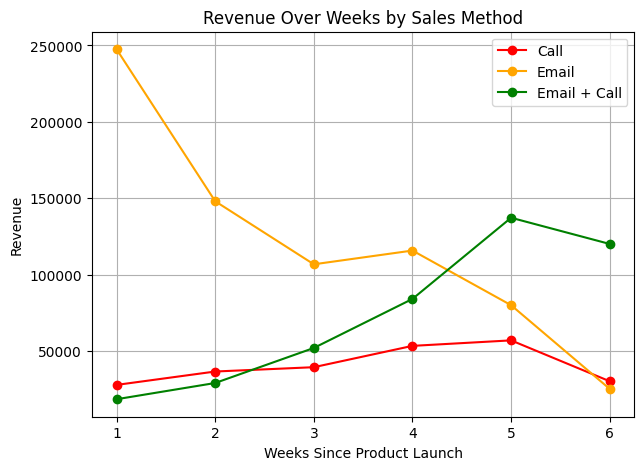

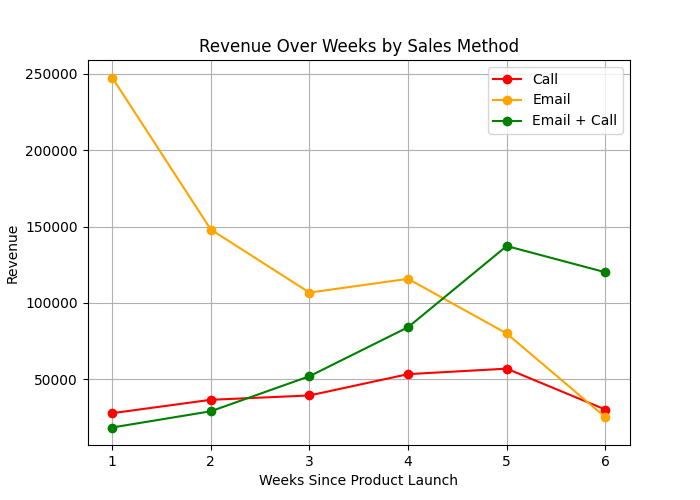

In [23]:
#revenue over weeks by sales method
df = pd.DataFrame(data_cleaned)
colors = ['red', 'orange', 'green']

revenue_by_method = df.groupby(['week', 'sales_method']).sum().reset_index()

# line plot
plt.figure(figsize=(7, 5))

for idx, method in enumerate(revenue_by_method['sales_method'].unique()):
    plt.plot(revenue_by_method[revenue_by_method['sales_method'] == method]['week'],
             revenue_by_method[revenue_by_method['sales_method'] == method]['revenue'],
             marker='o', label=method, color=colors[idx])

plt.title('Revenue Over Weeks by Sales Method')
plt.xlabel('Weeks Since Product Launch')
plt.ylabel('Revenue')
plt.xticks(revenue_by_method['week'].unique())
plt.grid()
plt.legend()
plt.savefig('weekly_revenue_by_sales_method.png')
plt.show()

Image(filename="weekly_revenue_by_sales_method.png")

* **Email**: Initially, the highest revenue (around 250,000) came from email during the first week but dropped sharply afterward, stabilizing at a much lower level (around 100,000) by week 3 and then fluctuating slightly.
* **Email + Call**: Revenue steadily increased, starting lower but overtaking Email by week 5, peaking around 150,000, and slightly declining afterward.
* **Call**: Revenue remained consistently low across all six weeks, with a small increase around week 5 but still the lowest overall.

The Email method generated the highest initial revenue but experienced a sharp decline after the first week. In contrast, the Email + Call approach demonstrated the strongest sustained growth, ultimately surpassing Email by week 5. The Call method consistently produced low revenue, making it the least effective option throughout the entire period. Overall, the combined Email + Call method appears to be more effective for long-term revenue growth, while Email performed well initially but quickly lost momentum.

# Metrics to Monitor


In [ ]:
#average revenue per customer
avg_revenue_per_customer = data_cleaned.groupby('customer_id')['revenue'].mean().mean()
print(f"Average Revenue per Customer: ${avg_revenue_per_customer:.2f}")

Average Revenue per Customer: $93.94


In [ ]:
#revenue per sales method (rounded)
revenue_per_method = round(data_cleaned.groupby('sales_method')['revenue'].mean(), 2)
print(f"Average Revenue per Sales Method:\n{revenue_per_method}")

Average Revenue per Sales Method:
sales_method
Call             49.29
Email            96.90
Email + Call    171.48
Name: revenue, dtype: float64


In [ ]:
#average site visits per customer
avg_site_visits_per_customer = data_cleaned.groupby('customer_id')['nb_site_visits'].mean().mean()
print(f"Average Site Visits per Customer: {avg_site_visits_per_customer:.2f}")

Average Site Visits per Customer: 24.99


In [ ]:
revenue_per_state = data_cleaned.groupby('state')['revenue'].mean()
print(f"Average Revenue per State:\n{revenue_per_state}")

Average Revenue per State:
state
Alabama            96.780744
Alaska             91.741618
Arizona            92.347316
Arkansas           91.745979
California         92.720079
Colorado           92.331778
Connecticut        97.652901
Delaware          101.128371
Florida            94.002960
Georgia            94.377348
Hawaii             97.157288
Idaho             101.712820
Illinois           91.573230
Indiana            93.673767
Iowa               90.978269
Kansas             92.697917
Kentucky           93.870490
Louisiana          94.830713
Maine              88.904680
Maryland           93.080414
Massachusetts      93.469485
Michigan           95.242426
Minnesota          93.671567
Mississippi       100.094242
Missouri           90.700301
Montana            83.848886
Nebraska           97.919722
Nevada             98.600242
New Hampshire      92.591032
New Jersey         91.089742
New Mexico         97.699342
New York           92.686473
North Carolina     89.634561
North Dako

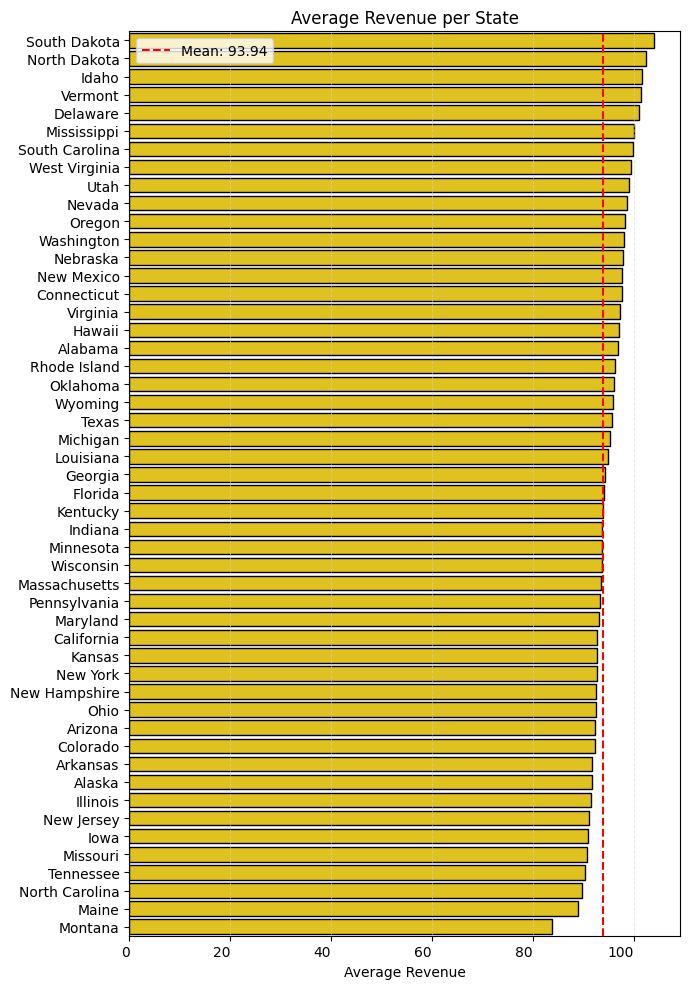

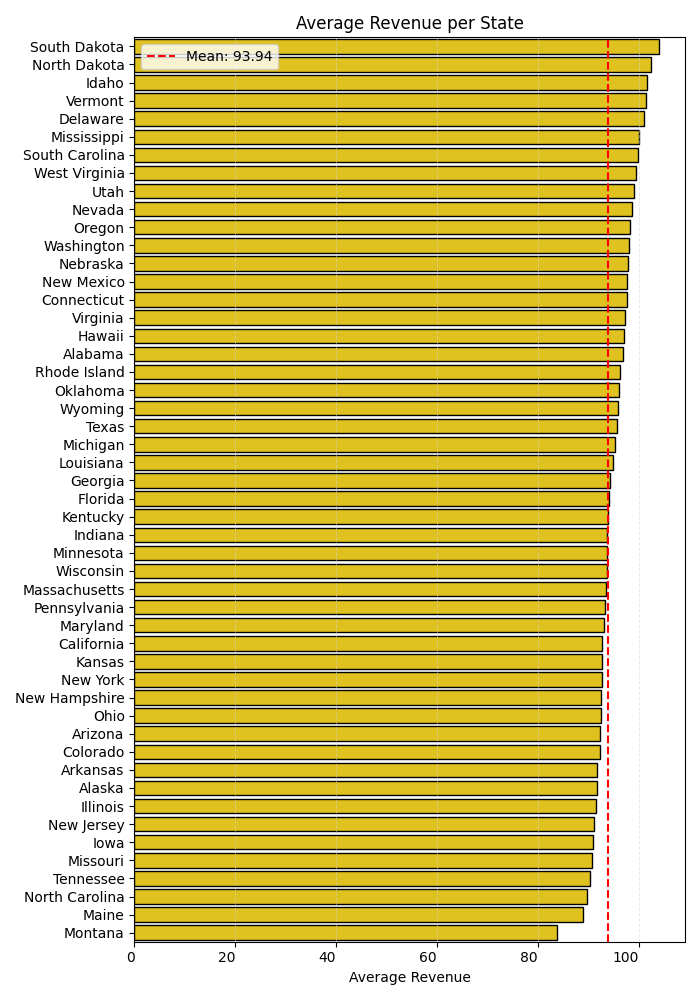

In [22]:
#average revenue by state
revenue_per_state = data_cleaned.groupby('state')['revenue'].mean().sort_values(ascending=False)
overall_mean = data_cleaned['revenue'].mean()

# bar plot
plt.figure(figsize=(7, 10))
sns.barplot(y=revenue_per_state.index,
            x=revenue_per_state.values,
            color='gold',
            edgecolor='black')

plt.title('Average Revenue per State')
plt.ylabel('')
plt.xlabel('Average Revenue')
plt.xticks(ha='right')
plt.axvline(overall_mean, color='red', linestyle='--', label=f'Mean: {overall_mean:.2f}')
plt.grid(axis='x', color='lightgrey', linestyle='--', linewidth=0.7, alpha=0.5)
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('average_site_visits_per_customer.png')
plt.show()

Image(filename="average_site_visits_per_customer.png")

While some states, like South Dakota and North Dakota, slightly outperform others, there is **generally little variation in average revenue across states**. This suggests that the **sales methods are similarly effective across regions**, with no significant outliers in terms of under- or overperformance. This consistency could support the decision to maintain broad, standardized sales strategies, though more regional analysis might uncover other factors affecting revenue.

# Conclusion
Based on the comprehensive analysis of the sales methods employed for the new product line, the
following summary have been drawn:

The **Email** method is the most efficient in terms of broad outreach and consistent revenue generation,
engaging the highest number of customers. The **Call** method, while fostering engagement, requires
significant resources and may not yield proportional revenue increases. Its effectiveness needs further
evaluation. The **Email + Call** hybrid approach shows potential for higher sales but requires strategic
targeting of leads to justify the additional resources involved.
### 4.2 Recommendations
1. **Prioritize Email**:
  * Leverage the Email method for broader outreach, utilizing automated tools to manage large
  volumes effectively.
  * Consider enhancing the content and targeting of email campaigns to further improve engagement
  and revenue.
2. **Evaluate Call Strategy**:
  * Conduct a cost-benefit analysis of the Call method, focusing on high-value leads to ensure efficient
  use of resources.
  conversion rates.
  * Explore the feasibility of training sales personnel to maximize the effectiveness of calls and improve
3. **Test Email + Call**:
  * Implement the hybrid Email + Call approach on a limited scale to assess its viability. Target high-
  potential leads to measure the effectiveness of combining both methods.
  * Monitor the results closely to determine if the increased effort translates into significant revenue
  gains.
4. **Monitor Metrics Closely**:
  * Establish a routine for monitoring the three defined metrics: Average Revenue per Customer,
  Revenue per -Sales Method, and Average Site Visits per Customer.
  * Use these insights to adjust strategies in real-time, ensuring that the business remains responsive to
  customer behaviors and market trends.
5. **Consider Regional Analysis**:
  * Although the average revenue across states shows little variation, further regional analysis may
  uncover other factors affecting revenue. This insight could inform tailored sales strategies that cater
  to specific regions.

##Conclusion
In conclusion, our analysis highlights critical insights into customer engagement strategies, revealing that
the Email method engages 7,465 customers and generates consistent revenue, while the Call method
shows lower performance with a median revenue of approximately 50. By implementing targeted
recommendations, such as prioritizing Email outreach and evaluating the hybrid Email + Call approach,
the business can optimize resource allocation and enhance customer interactions. This data-driven
strategy establishes a framework for ongoing performance monitoring, positioning the organization to
leverage real-time insights for sustained growth in a competitive market.